Intelligent enhancement of image spatial resolution
Performance shall be compared with the usual cv2 resizing

In [69]:
import os
import cv2
# from skimage.transform import resize, rescale
import numpy as np
import re 
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras import Model, models, losses
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from scipy import ndimage, misc 
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
from time import time
import math

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

SIZE = 256

In [70]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

def get_images_in_order(path):
    images = []
    files = os.listdir(path)
    files = sorted_alphanumeric(files)
    print(files)

    for i in files:       
        img = cv2.imread(path + '/'+i,1)
    # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        images.append(img_to_array(img))

    return images

def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

# Defining Image Quality Matric Functions
def psnr(target, ref):

    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])

    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))

    return scores

In [4]:

high_img = []
path = 'E:\education\ComputerVision\cv_curs_work\dataset\Raw Data'
high_path = path + '\high_res'
low_path = path + '\low_res'

high_img = get_images_in_order(high_path)
low_img = get_images_in_order(low_path)

['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png'

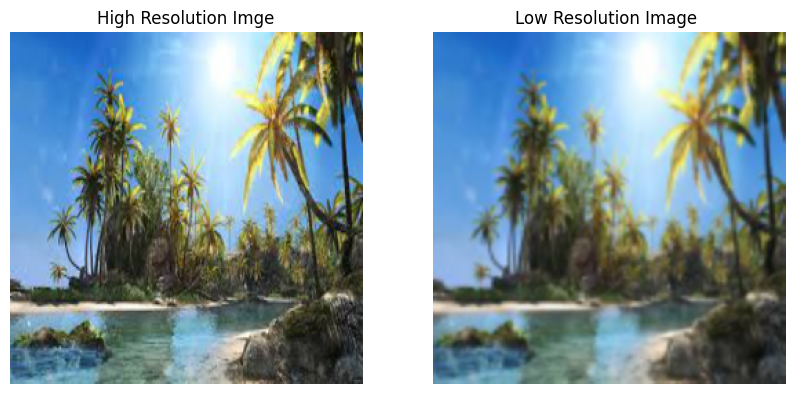

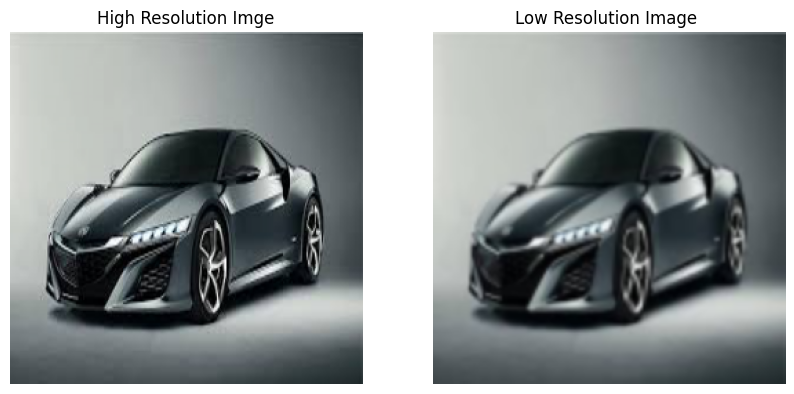

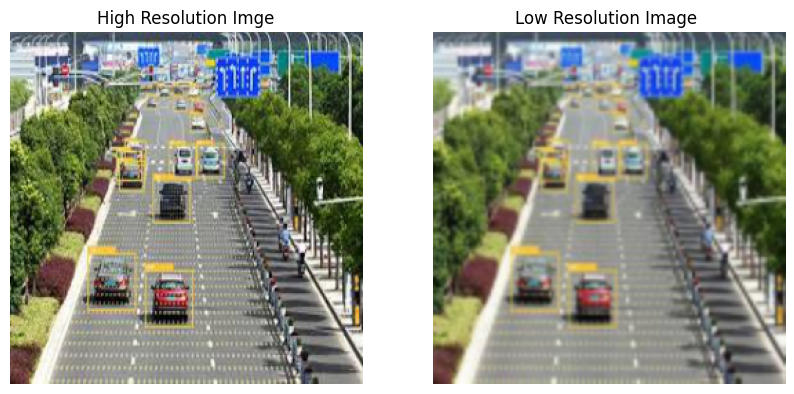

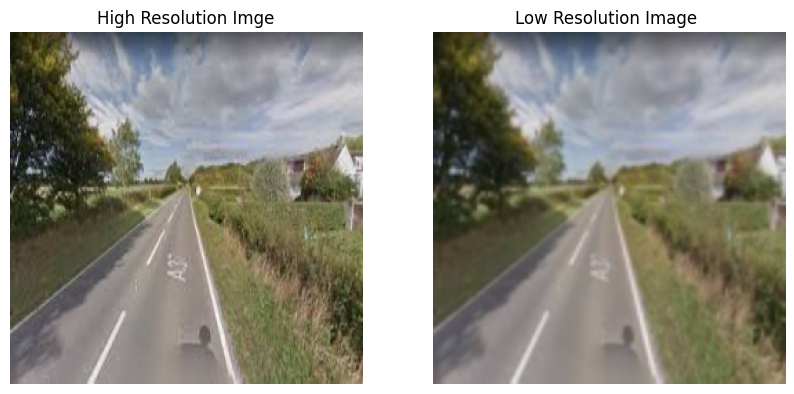

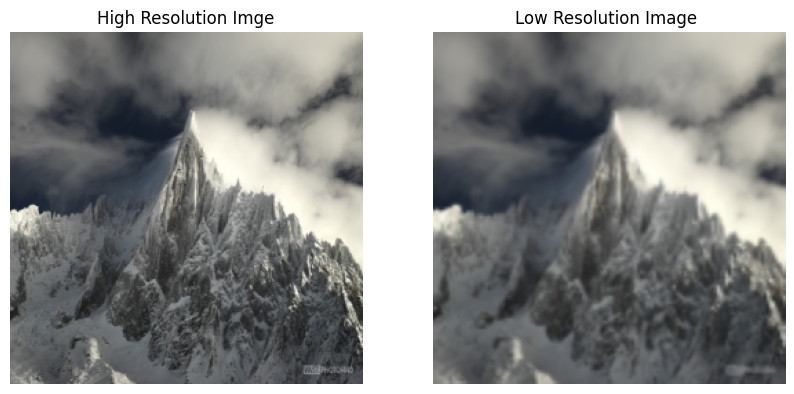

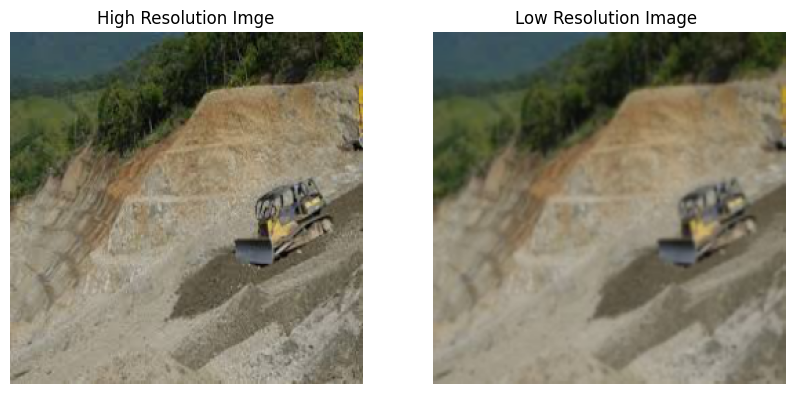

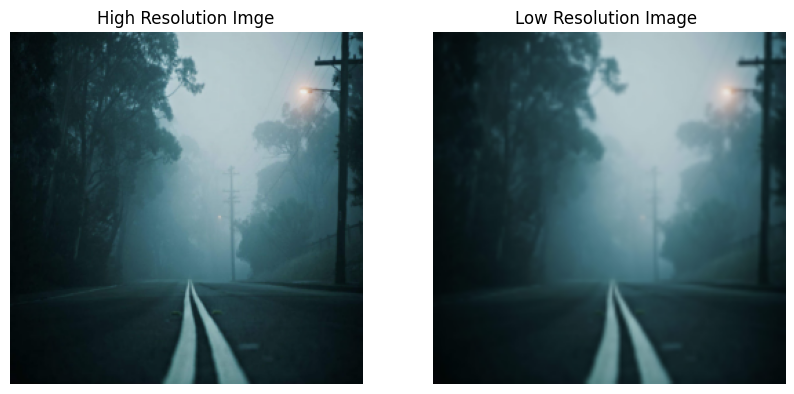

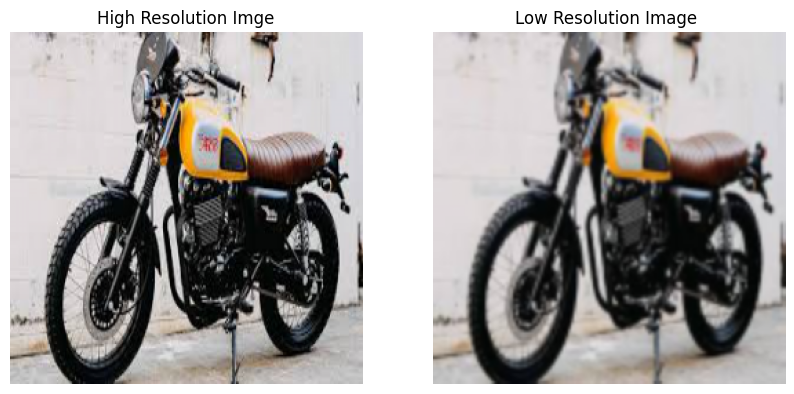

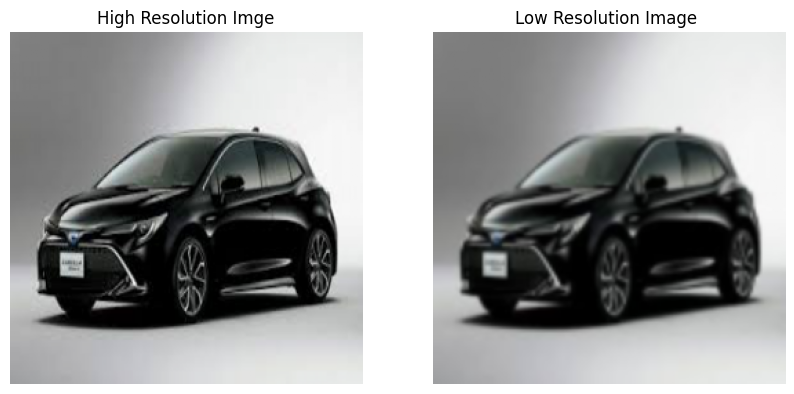

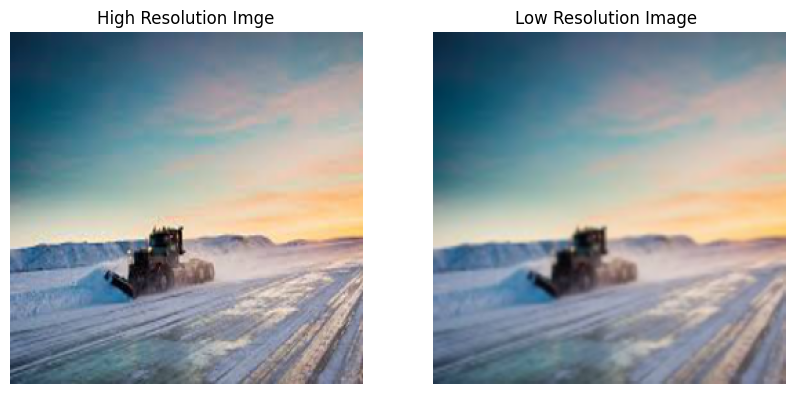

In [5]:
for i in range(10):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge')
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Low Resolution Image ')
    plt.imshow(low_img[a])
    plt.axis('off')

In [12]:
#split data in 3 sections [train, validation, test]

train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.array(train_high_image)
train_low_image = np.array(train_low_image)

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image = np.array(validation_high_image)
validation_low_image = np.array(validation_low_image)

test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image = np.array(test_high_image)
test_low_image = np.array(test_low_image)

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 256, 256, 64)   │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 256, 256, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 256, 256, 3)    │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,099 (78.51 KB)

 Trainable params: 20,099 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

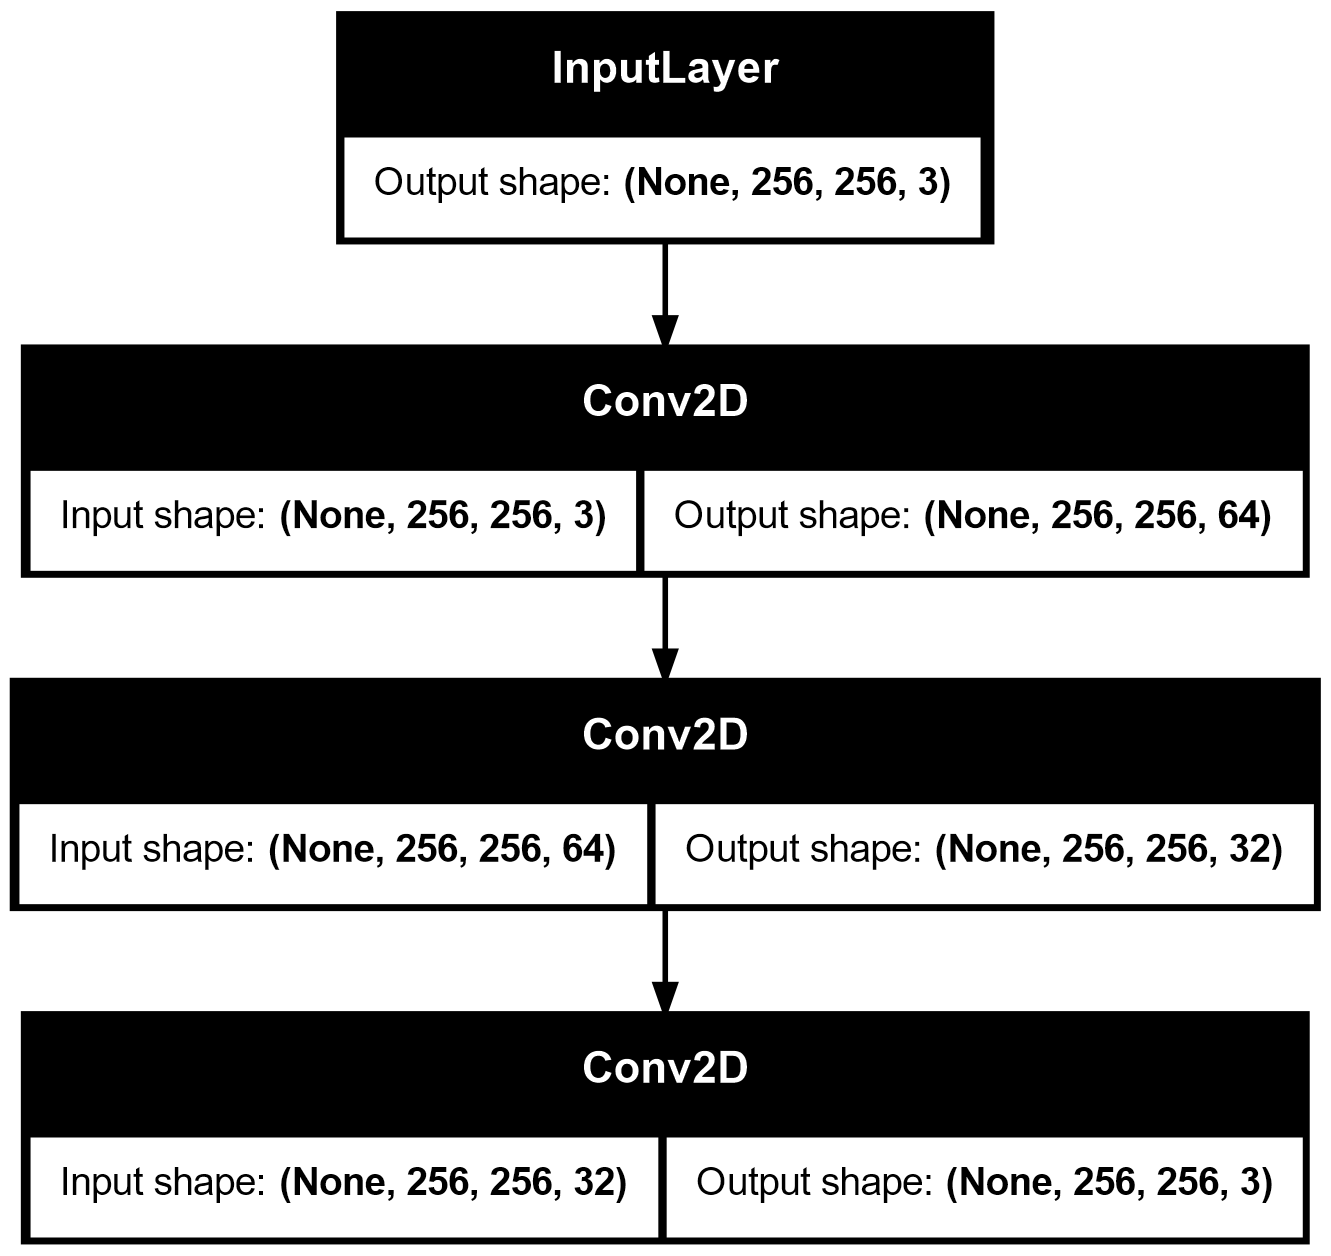

In [55]:
input_img=Input(shape=(SIZE,SIZE,3))
l1=tf.keras.layers.Conv2D(64,9,padding='same',activation='relu') (input_img)
l2=tf.keras.layers.Conv2D(32,1,padding='same',activation='relu') (l1)
l3=tf.keras.layers.Conv2D(3,5,padding='same',activation='relu') (l2)

SRCNN=Model(input_img,l3)

SRCNN.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss="mean_squared_error", metrics=["accuracy"])
SRCNN.summary()
plot_model(SRCNN, show_shapes=True)

In [62]:
#Training

history = SRCNN.fit(train_low_image, train_high_image, epochs = 50, batch_size = 5,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.8495 - loss: 0.0010 - val_accuracy: 0.8922 - val_loss: 0.0012
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.8078 - loss: 0.0012 - val_accuracy: 0.9163 - val_loss: 0.0013
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.7909 - loss: 0.0014 - val_accuracy: 0.7210 - val_loss: 0.0016
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.7920 - loss: 0.0013 - val_accuracy: 0.9248 - val_loss: 0.0011
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.8620 - loss: 0.0010 - val_accuracy: 0.8950 - val_loss: 0.0012
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - accuracy: 0.8085 - loss: 0.0012 - val_accuracy: 0.8693 - val_loss: 0.0011
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.8721 - loss: 0.0010 - val_accuracy: 0.8862 - val_loss: 0.0012
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.8439 - loss: 0

Train Acc      0.8452760577201843
Validation Acc 0.8308140635490417


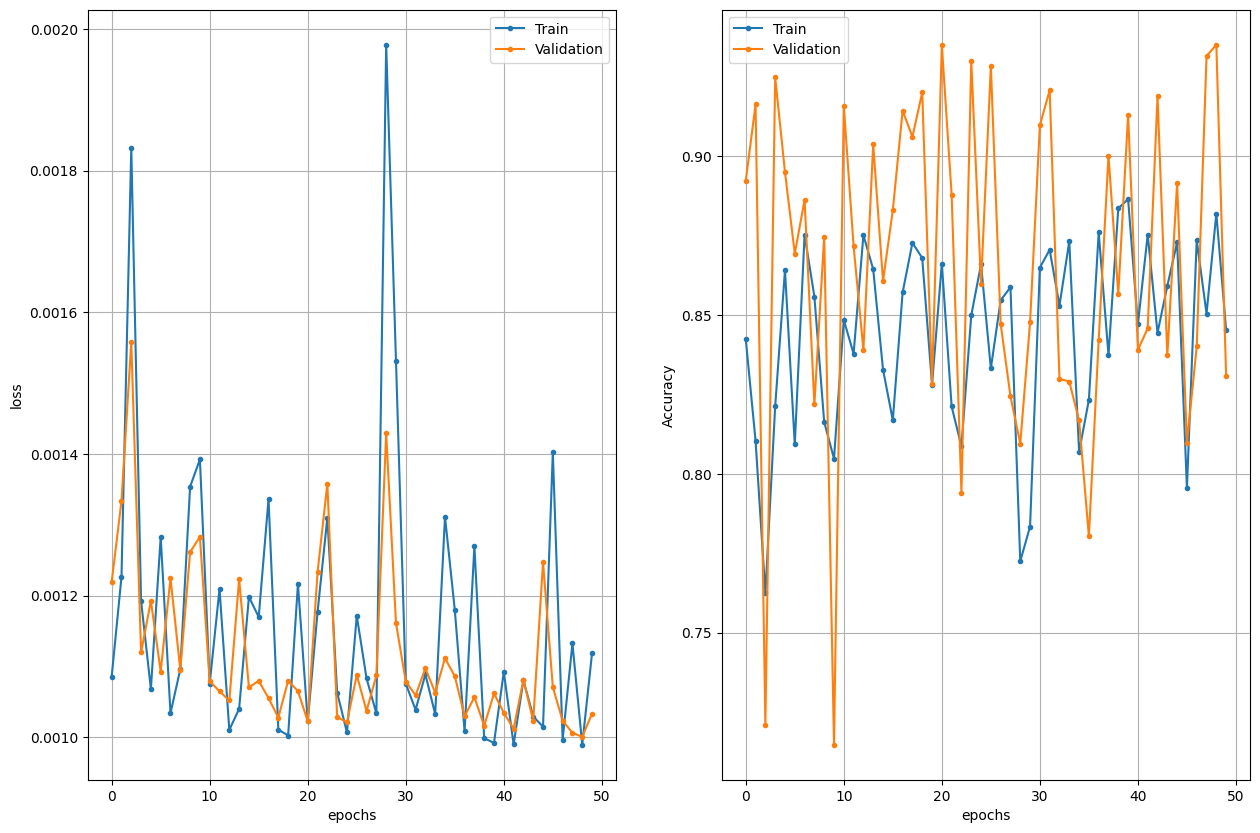

In [63]:
plot_history(history)

In [64]:
SRCNN.save('srcnn_model.keras')

In [61]:
SRCNN = models.load_model('srcnn_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

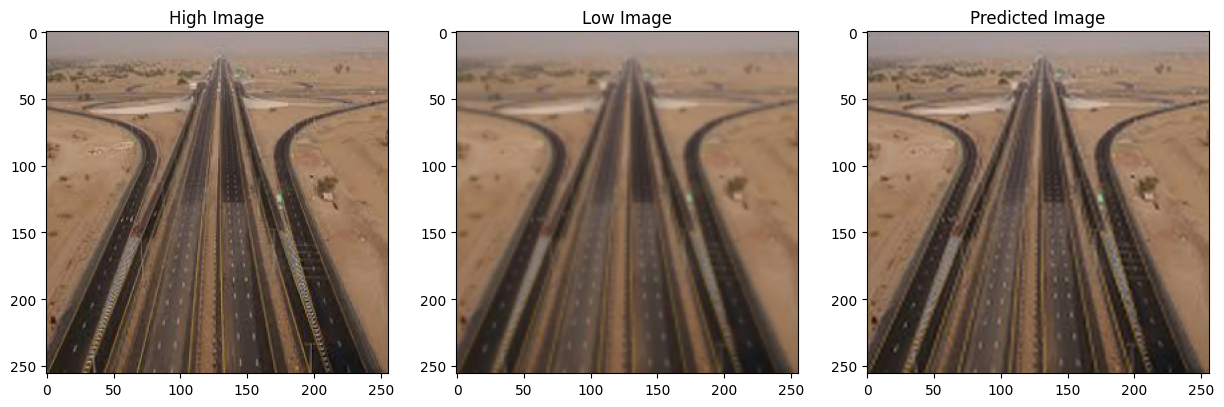

In [71]:
for i in range(25):
    predict = np.clip(SRCNN.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image')
    plt.imshow(test_high_image[i])
    plt.subplot(1,3,2)
    plt.title('Low Image')
    plt.imshow(test_low_image[i])
    plt.subplot(1,3,3)
    plt.title('Predicted Image')
    plt.imshow(predict)
    degradated = compare_images(test_high_image[i], test_low_image[i])
    reconstucted = compare_images(test_high_image[i], predict[i])

    print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(degradated[0], degradated[1], degradated[2]))
    print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(reconstucted[0], reconstucted[1], reconstucted[2]))
plt.show()